In [ ]:
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import time
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import random
import math
from scipy.linalg import eigh
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import gdown
import idx2numpy

##Creating Data Points


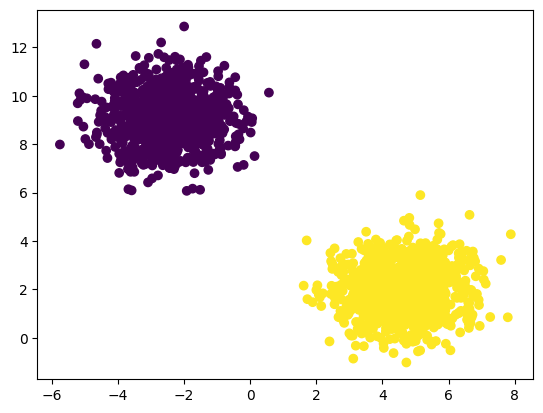

In [ ]:
NUM_ITER = 200
pca_number = 2
data_points_mnsit = 3000
cpu_times = {}

def create_data_points(toy_data_flag = True):
  if toy_data_flag:
    # generate 10,000 random data points with 2 features and 2 labels
    X, y = make_blobs(n_samples=2000, centers=2, n_features=2, random_state=42)
    # plot the data points in a 2D scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

  else: 
    # File URLs
    url_train_labels = 'https://drive.google.com/uc?id=1fP9ddqgR8GkN__N2sYuBINEAGfgLecp-'
    url_train_images = 'https://drive.google.com/uc?id=1Q4SrIqLvsq69uL_4YlFNKYJDqbQMVPJj'

    # Output file paths
    output_train_labels = '/content/train-labels.idx1-ubyte'
    output_train_images = '/content/train-images.idx1-ubyte'

    # Downloading the files
    gdown.download(url_train_labels, output_train_labels, quiet=False)
    gdown.download(url_train_images, output_train_images, quiet=False)


    # Load the MNIST dataset into numpy arrays and take the first 1000 examples
    train_images = idx2numpy.convert_from_file('/content/train-images.idx1-ubyte')[:data_points_mnsit]
    train_labels = idx2numpy.convert_from_file('/content/train-labels.idx1-ubyte')[:data_points_mnsit]

    train_images = np.reshape(train_images, (train_images.shape[0], -1))
    X_train_val_norm = train_images.astype('float32') / 255

    #define a scaler
    scaler = StandardScaler()
    scaler.fit(X_train_val_norm) #remember, always training! 
    X_train_scl = scaler.transform(X_train_val_norm)

    # Change labels 0 if labels 0 else 1 for any other labels
    y = np.array([0 if label == 0 else 1 for label in train_labels])
    X = X_train_scl

    # Apply PCA to X to reduce the number of features to 2
    pca = PCA(n_components=pca_number)
    X_pca = pca.fit_transform(X)

    # Convert the transformed features to a 2D NumPy array
    X = np.array(X_pca)

    # Print the shape of the array
    X.shape,y.shape

    # Show data spread
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

    # Show one of 0 picture and its label
    image = X_train_scl[51, :].reshape((28, 28))
    print(train_labels[51])
    plt.imshow(image)
    plt.show()

  return X, y
  
X, y = create_data_points(toy_data_flag = True)

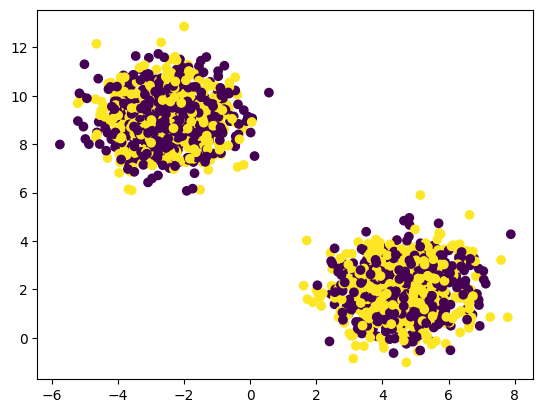

In [ ]:
# set the seed for reproducibility
np.random.seed(42)

#make %90 of data points unlabeled
num_unlabeled = int(0.9 * len(y))
unlabeled_indices = np.random.choice(len(y), size=num_unlabeled, replace=False)
labeled_indices = np.array(list(set(np.array(range(len(y)))) - set(unlabeled_indices)))

#hold initially labeled then unlabeled points
initial_unlabeled_labels = np.copy(y[unlabeled_indices])

#initialize the labels of the unlabeled points with a Gaussian distribution
unlabeled_labels = np.random.choice([0, 1], size=num_unlabeled)

#clip the labels between (0,1)
unlabeled_labels = np.clip(unlabeled_labels, 0, 1)

#assign labels to selected indices
y[unlabeled_indices] = unlabeled_labels

# plot the data points in a 2D scatter plot
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [ ]:
len(labeled_indices), len(unlabeled_indices)

(200, 1800)

In [ ]:
def weights_labeled_unlabeled():
    labeled_unlabeled = euclidean_distances(X[labeled_indices], X[unlabeled_indices]) / X[labeled_indices].shape[1]
    return math.e**(-10* labeled_unlabeled**2)
print("Weights labeled unlabeled calcualted")

w_labeled_unlabeled = weights_labeled_unlabeled()

def weights_unlabeled_unlabeled():
    unlabeled_unlabeled = euclidean_distances(X[unlabeled_indices], X[unlabeled_indices]) / X[unlabeled_indices].shape[1]
    return math.e**(-10* unlabeled_unlabeled**2)
print("Weights unlabeled unlabeled calcualted")

w_unlabeled_unlabeled = weights_unlabeled_unlabeled()

Weights labeled unlabeled calcualted
Weights unlabeled unlabeled calcualted


Loss function as follows:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$

In [ ]:
def loss_fast(labeled, unlabeled):
    Y_unlabeled = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_labeled = np.copy(labeled).astype("float64").reshape((-1,1))

    # Calculate first double sum
    Y_minus_Y_bar = Y_unlabeled-Y_labeled.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    lu_loss = np.sum(Y_minus_Y_bar_sq * w_labeled_unlabeled.T)

    # Calculate second double sum
    Y_minus_Y = Y_unlabeled-Y_unlabeled.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    ul_loss = np.sum(Y_minus_Y_sq * w_unlabeled_unlabeled.T)

    return lu_loss + ul_loss/2

In [ ]:
def accuracy(y_pred, y_initial_unlabeled = initial_unlabeled_labels):
  num_correct = np.sum(np.round(y_pred) == y_initial_unlabeled)
  return num_correct / len(y_initial_unlabeled)

In [ ]:
def plot_accuracy_loss(accuracy_list,loss,acc_name,loss_name):

  print("accuracy: {:.3f} ---- loss: {:.3f}".format(accuracy_list[-1], loss[-1]))
  # create a figure with two subplots
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

  # plot the first graph on the left subplot
  axs[0].set_title(acc_name)
  axs[0].plot(accuracy_list_gd, marker='.')
  axs[0].set_xlabel("Iteration")
  axs[0].set_ylabel("Accuracy")

  # plot the second graph on the right subplot
  axs[1].set_title(loss_name)
  axs[1].plot(loss_gd)
  axs[1].set_xlabel("Iteration")
  axs[1].set_ylabel("Loss")

  # adjust the spacing between the subplots
  plt.tight_layout()

  # display the plot
  plt.show()

Gradient function is follows:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i)\end{align*}
$$

In [ ]:
def gradient_single_iter(unlabeled, j):
    total_lu = np.sum((unlabeled[j] - y[labeled_indices]) * w_labeled_unlabeled.T[j])
    total_uu = np.sum((unlabeled[j] - unlabeled) * w_unlabeled_unlabeled.T[j])
    return total_lu * 2 + total_uu

def calculate_gradient(unlabeled):
  weighted_diff = (unlabeled.reshape((-1,1)) - y[labeled_indices])* w_labeled_unlabeled.T 
  grad_lu = np.sum(weighted_diff,axis=1) 

  weighted_diff = (unlabeled.reshape((-1,1)) - unlabeled)* w_unlabeled_unlabeled.T 
  grad_uu = np.sum(weighted_diff,axis=1) 
  
  return grad_lu * 2 + grad_uu 

Hessian as follows:

$$
\begin{align*}
\frac{{\partial}}{{\partial y_1}}(\nabla_{y^1}f(y))$ &= 2 \sum_{i=0}^lw_{i1} + \sum_{i=0}^u\bar{w}_{i1} - \bar{w}_{i1}\end{align*}
$$

$$
\frac{{\partial}}{{\partial y_2}}(\nabla_{y^1}f(y)) = - \bar{w}_{21}
$$

In [ ]:
'''def hessian_matrix():
  hessian = np.zeros_like(w_unlabeled_unlabeled)
  for i in range(len(unlabeled_indices)):
    for j in range(len(unlabeled_indices)):
      if i==j:
        hessian[i][j] = 2 * ( np.sum(w_labeled_unlabeled[:,j]) + np.sum(w_unlabeled_unlabeled[:,j]) + w_unlabeled_unlabeled[j,j] )
      else:
        hessian[i][j] = -2 * w_unlabeled_unlabeled[i][j]
  return hessian'''


def hessian_matrix():
  hessian = -1 * np.copy(w_unlabeled_unlabeled)
  for i in range(len(unlabeled_indices)):
    hessian[i][i] = 2 * ( np.sum(w_labeled_unlabeled[:,i]) ) + np.sum(w_unlabeled_unlabeled[:,i]) + w_unlabeled_unlabeled[i,i] 
  return hessian


def calculate_lipschitz_constant(hessian_matrix):
    eigenvalues, _ = eigh(hessian_matrix)
    lipschitz_constant = np.max(eigenvalues)
    return lipschitz_constant

In [ ]:
def armijo_rule(y_unlabeled, starting_learning_rate, delta, gamma, gradients, max_iter):
    """
    Args:
    - y_unlabeled: numpy array of shape (n_unlabeled,), unlabeled data points
    - starting_learning_rate: float, the initial learning rate
    - delta: float, constant in (0,1) representing the proportion by which we decrease the learning rate
    - gamma: float, constant in (0,1/2) representing the decrease rate of the learning rate
    - gradients: numpy array of shape (n_features,), the gradients of the loss function with respect to the weights
    - max_iter: integer, maximum number of iterations to run the Armijo rule for
    """
    
    # Initialize the step size
    alpha = starting_learning_rate

    # Compute the initial loss
    loss_func = loss_fast(y_labeled_gd, y_unlabeled)

    # Compute the squared norm of the gradient
    grad_norm_squared = np.dot(gradients.T, gradients)
    
    # Iterate up to max_iter times
    for i in range(max_iter):
        # Check the Armijo condition, i.e., whether the new loss is smaller than the old loss minus some threshold
        if loss_fast(y_labeled_gd, y_unlabeled - alpha * gradients) <= loss_func - gamma * alpha * grad_norm_squared:
            # If the condition is met, return the chosen learning rate
            return alpha
        else:
            # If the condition is not met, decrease the learning rate by a constant factor
            alpha *= gamma
            
    # If the maximum number of iterations is reached, return the current learning rate
    return alpha

##Gradient Descent

In [ ]:
y_unlabeled_gd = np.copy(y[unlabeled_indices]).astype(np.float64)
y_labeled_gd = np.copy(y[labeled_indices]).astype(np.float64)

In [ ]:
%%time
# Initialize the estimated y and the stepsize
accuracy_list_gd = []
loss_gd = []
stop_condition = False
ITERATION = 0

start_time = time.process_time()
while ITERATION < NUM_ITER:

  ITERATION+=1
  stop_condition = False

  # Check the stop condition
  if (stop_condition):
    break

  # Compute objective function for estimated y
  loss_gd.append(loss_fast(y_labeled_gd, y_unlabeled_gd))
  accuracy_list_gd.append(accuracy(y_unlabeled_gd))

  if ITERATION == 1 :
    print("iteration: 0 --- accuracy: {:.3f} ---- loss: {:.3f}".format(accuracy_list_gd[-1], loss_gd[-1]))

  #Calculate gradient with respect to i
  grad = calculate_gradient(y_unlabeled_gd)

  #Armijo Rule to update stepsize
  stepsize = armijo_rule(y_unlabeled_gd, starting_learning_rate = 1, delta = 0.5, gamma = 0.4999, gradients = grad, max_iter = 14)     

  # Update the estimated y
  y_unlabeled_gd = y_unlabeled_gd - stepsize * grad

  if ITERATION % 20 == 0 :
    print("iteration: {} --- accuracy: {:.3f} ---- loss: {:.3f}".format(ITERATION, accuracy_list_gd[-1], loss_gd[-1]))

end_time = time.process_time()
cpu_time = end_time - start_time
cpu_times["gradient descent"] = cpu_time

iteration: 0 --- accuracy: 0.504 ---- loss: 45099.387
iteration: 20 --- accuracy: 0.993 ---- loss: 30.626
iteration: 40 --- accuracy: 0.998 ---- loss: 4.631
iteration: 60 --- accuracy: 0.998 ---- loss: 1.489
iteration: 80 --- accuracy: 0.998 ---- loss: 0.637
iteration: 100 --- accuracy: 0.998 ---- loss: 0.370
iteration: 120 --- accuracy: 0.998 ---- loss: 0.278
iteration: 140 --- accuracy: 0.998 ---- loss: 0.236
iteration: 160 --- accuracy: 0.998 ---- loss: 0.210
iteration: 180 --- accuracy: 0.998 ---- loss: 0.189
iteration: 200 --- accuracy: 0.998 ---- loss: 0.173
CPU times: user 4min 15s, sys: 41.7 s, total: 4min 56s
Wall time: 5min 17s


accuracy: 0.998 ---- loss: 0.173


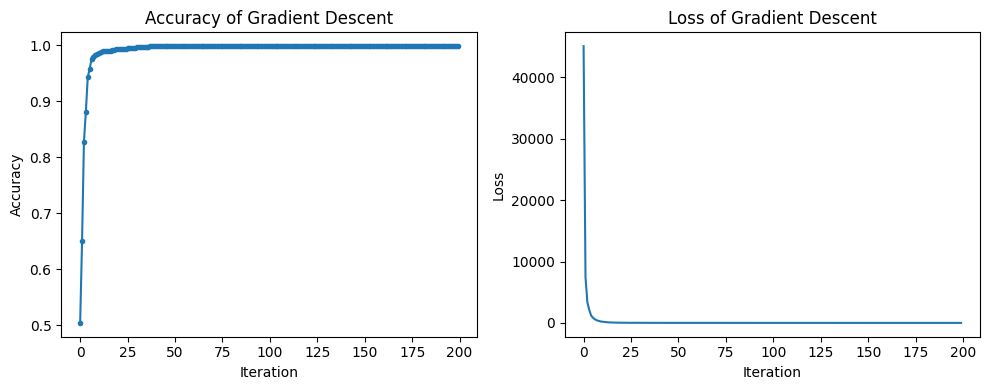

In [ ]:
plot_accuracy_loss(accuracy_list_gd,loss_gd, "Accuracy of Gradient Descent", "Loss of Gradient Descent")

##Randomized BCGD

In [ ]:
y_unlabeled_rbcgd = np.copy(y[unlabeled_indices]).astype(np.float64)
y_labeled_rbcgd = np.copy(y[labeled_indices]).astype(np.float64)

In [ ]:
%%time
# Calculate Lipschitz constant
hessian = hessian_matrix()
Li = calculate_lipschitz_constant(hessian)
stepsize = 1/Li

CPU times: user 3.13 s, sys: 285 ms, total: 3.42 s
Wall time: 2.06 s


In [ ]:
%%time
# Initialize the estimated y and the stepsize
accuracy_list_rbcgd = []
losses_gd = []

# Initialize a vector for values of the objective function
loss_rbcgd = []

# Implementation of Randomized BCGD
stop_condition = False
ITERATION = 0

start_time = time.process_time()
while ITERATION < NUM_ITER:
  ITERATION+=1
  stop_condition = False

  # Check the stop condition
  if (stop_condition):
    break

  # Compute objective function for estimated y
  loss_rbcgd.append(loss_fast(y_labeled_rbcgd, y_unlabeled_rbcgd))
  accuracy_list_rbcgd.append(accuracy(y_unlabeled_rbcgd))

  if ITERATION == 1 :
    print("iteration: 0 --- accuracy: {:.3f} ---- loss: {:.3f}".format(accuracy_list_gd[-1], loss_gd[-1]))

  for i in range(len(y_unlabeled_rbcgd)):

      # Choosing random block
      rand_block = np.random.randint(len(y_unlabeled_rbcgd))

      #Calculate gradient with respect to i
      grad = gradient_single_iter(y_unlabeled_rbcgd, rand_block)
        
      # Stopping condition
      if(abs(grad) < 0.00001):
        stop_condition = True

      # Update the estimated y
      y_unlabeled_rbcgd[rand_block] = y_unlabeled_rbcgd[rand_block] - stepsize * grad

  if ITERATION % 20 == 0 or ITERATION == 2:
    print("iteration: {} --- accuracy: {:.3f} ---- loss: {:.3f}".format(ITERATION, accuracy_list_rbcgd[-1], loss_rbcgd[-1]))

end_time = time.process_time()
cpu_time = end_time - start_time
cpu_times["Randomized BCGD"] = cpu_time


iteration: 0 --- accuracy: 0.998 ---- loss: 0.173
iteration: 2 --- accuracy: 0.617 ---- loss: 21496.419
iteration: 20 --- accuracy: 0.984 ---- loss: 253.069
iteration: 40 --- accuracy: 0.992 ---- loss: 36.781
iteration: 60 --- accuracy: 0.994 ---- loss: 11.647
iteration: 80 --- accuracy: 0.998 ---- loss: 5.661
iteration: 100 --- accuracy: 0.998 ---- loss: 3.149
iteration: 120 --- accuracy: 0.998 ---- loss: 1.970
iteration: 140 --- accuracy: 0.998 ---- loss: 1.382
iteration: 160 --- accuracy: 0.998 ---- loss: 0.995
iteration: 180 --- accuracy: 0.998 ---- loss: 0.727
iteration: 200 --- accuracy: 0.998 ---- loss: 0.570
CPU times: user 51.5 s, sys: 5.35 s, total: 56.8 s
Wall time: 57.1 s


accuracy: 0.998 ---- loss: 0.570


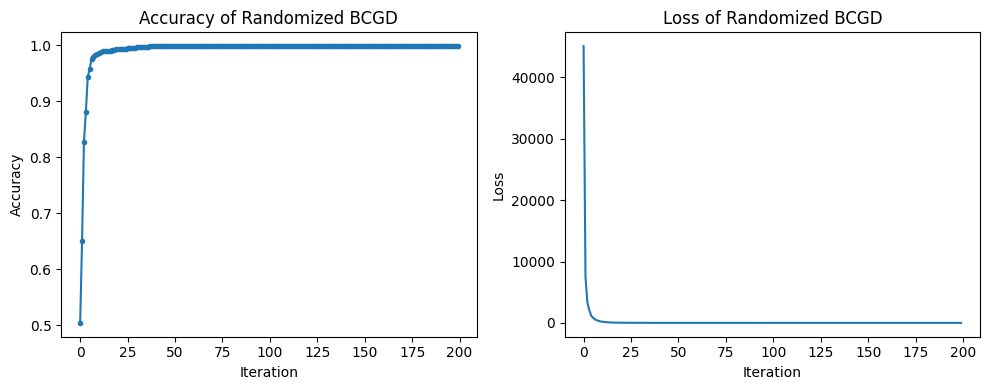

In [ ]:
plot_accuracy_loss(accuracy_list_rbcgd,loss_rbcgd, "Accuracy of Randomized BCGD", "Loss of Randomized BCGD")

##BCGD with Gauss-Southwell

In [ ]:
y_unlabeled_gs = np.copy(y[unlabeled_indices]).astype(np.float64)
y_labeled_gs = np.copy(y[labeled_indices]).astype(np.float64)

In [ ]:
%%time
# Initialize the estimated y and the stepsize
accuracy_list_gs = []
losses_gs = []

# Initialize a vector for values of the objective function
loss_gs = []

# Implementation of Randomized BCGD
stop_condition = False
ITERATION = 0

start_time = time.process_time()
#Get all the gradients
previous_grad_gs = []
for i in range(len(y_unlabeled_gs)):
  previous_grad_gs.append(gradient_single_iter(y_unlabeled_gs, i))


while ITERATION < NUM_ITER:
  ITERATION+=1
  stop_condition = False

  # Check the stop condition
  if (stop_condition):
    break

  # Compute objective function for estimated y
  loss_gs.append(loss_fast(y_labeled_gs, y_unlabeled_gs))
  accuracy_list_gs.append(accuracy(y_unlabeled_gs))
  
  if ITERATION == 1 :
    print("iteration: 0 --- accuracy: {:.3f} ---- loss: {:.3f}".format(accuracy_list_gd[-1], loss_gd[-1]))

  for i in range(len(y_unlabeled_gs)):
      
    #Get the highest gradient index
    max_index = np.argmax(np.abs(previous_grad_gs))

    #Calculate gradient at that point
    grad = gradient_single_iter(y_unlabeled_gs, max_index)

    # Stopping condition
    if(abs(grad) < 0.00001):
      stop_condition = True
      print("stopped condition reached")

    # Update the estimated y
    y_unlabeled_gs[max_index] = y_unlabeled_gs[max_index] - stepsize * grad

    # Update gradient list
    previous_grad_gs[max_index] = grad

  if ITERATION % 20 == 0 or ITERATION == 2:
    print("iteration: {} --- accuracy: {:.3f} ---- loss: {:.3f}".format(ITERATION,accuracy_list_gs[-1], loss_gs[-1]))

end_time = time.process_time()
cpu_time = end_time - start_time
cpu_times["BCGD with Gauss-Southwell"] = cpu_time

iteration: 0 --- accuracy: 0.998 ---- loss: 0.173
iteration: 2 --- accuracy: 0.803 ---- loss: 8836.722
iteration: 20 --- accuracy: 0.998 ---- loss: 140.720
iteration: 40 --- accuracy: 0.999 ---- loss: 57.047
iteration: 60 --- accuracy: 1.000 ---- loss: 31.514
iteration: 80 --- accuracy: 1.000 ---- loss: 21.451
iteration: 100 --- accuracy: 1.000 ---- loss: 13.457
iteration: 120 --- accuracy: 1.000 ---- loss: 7.412
iteration: 140 --- accuracy: 1.000 ---- loss: 5.497
iteration: 160 --- accuracy: 1.000 ---- loss: 4.164
iteration: 180 --- accuracy: 1.000 ---- loss: 3.615
iteration: 200 --- accuracy: 1.000 ---- loss: 2.916
CPU times: user 1min 23s, sys: 5.31 s, total: 1min 29s
Wall time: 1min 29s


accuracy: 1.000 ---- loss: 2.916


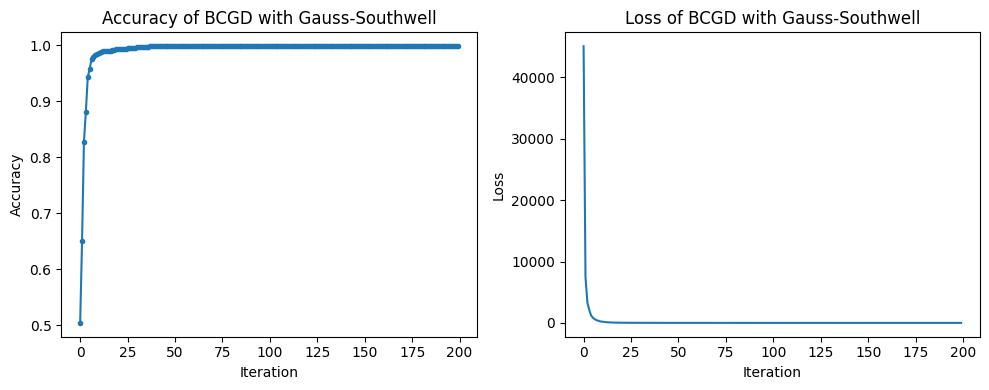

In [ ]:
plot_accuracy_loss(accuracy_list_gs,loss_gs, "Accuracy of BCGD with Gauss-Southwell", "Loss of BCGD with Gauss-Southwell")

##General Comparison

In [ ]:
print("accuracy Standard GD': {:.3f} ---- loss: {:.3f}".format(accuracy_list_gd[-1], loss_gd[-1]))
print("accuracy Randomized GD: {:.3f} ---- loss: {:.3f}".format(accuracy_list_rbcgd[-1], loss_rbcgd[-1]))
print("accuracy Gauss-Southwell GD: {:.3f} ---- loss: {:.3f}".format(accuracy_list_gs[-1], loss_gs[-1]))

accuracy Standard GD': 0.998 ---- loss: 0.173
accuracy Randomized GD: 0.998 ---- loss: 0.570
accuracy Gauss-Southwell GD: 1.000 ---- loss: 2.916


In [ ]:
import pandas as pd
df_cpu_times = pd.DataFrame(sorted(cpu_times.items(), key=lambda x: x[1]), columns = ["optimizer", "cpu_time"])
df_cpu_times = df_cpu_times.set_index("optimizer")
df_cpu_times

,cpu_time
optimizer,
Randomized BCGD,56.817613
BCGD with Gauss-Southwell,89.195786
gradient descent,296.942383


<ipython-input-25-3c4792eb9c58>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


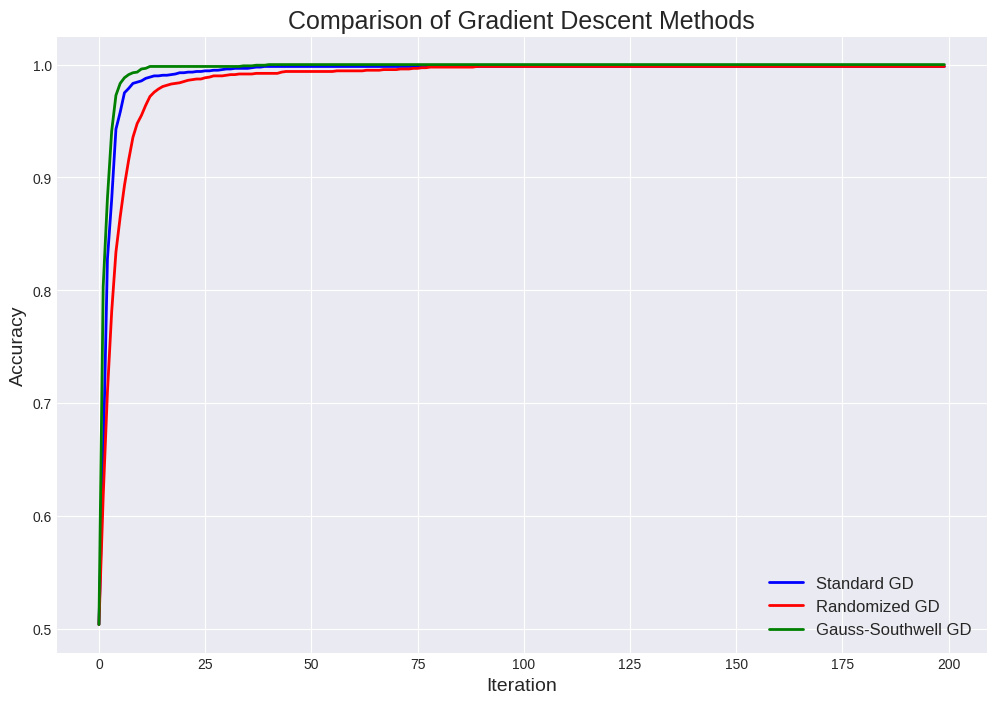

In [ ]:
# Set up plot style
plt.style.use('seaborn-darkgrid')

# Plot the functions
plt.figure(figsize=(12, 8))
plt.plot(accuracy_list_gd, linewidth=2, label='Standard GD', color='blue')
plt.plot(accuracy_list_rbcgd, linewidth=2, label='Randomized GD', color='red')
plt.plot(accuracy_list_gs, linewidth=2, label='Gauss-Southwell GD', color='green')

# Add axis labels and title
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of Gradient Descent Methods', fontsize=18)

# Add legend and adjust its properties
plt.legend(loc='lower right', prop={'size': 12})

# Save and show the plot
plt.savefig('gd_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Plot champ gradient method

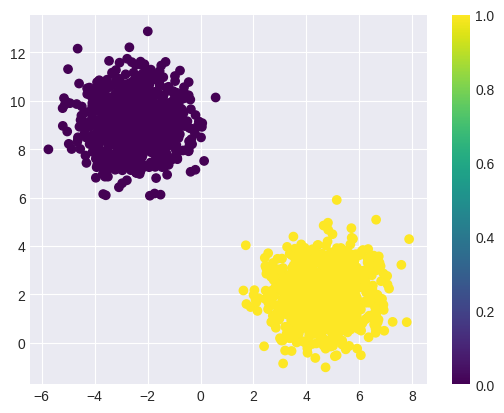

In [ ]:
champ_model = y_unlabeled_gs

def convert_probs(predicted):
  predicted_list = []
  for i in predicted:
    if i <= 0.5:
      predicted_list.append(0)
    else:
      predicted_list.append(1)   
  return predicted_list

champ_model_results = convert_probs(champ_model)

y_new = np.zeros_like(y)
y_new[labeled_indices] = y[labeled_indices]
y_new[unlabeled_indices] = champ_model_results

plt.scatter(X[:, 0], X[:, 1], c=y_new, cmap='viridis')
plt.colorbar()
plt.show()